##### Copyright 2021 Google LLC.
Licensed under the BSD 3-Clause License.

In [ ]:
#@title Licensed under the BSD-3 License (the "License"); { display-mode: "form" }
# Copyright 2021 Google LLC.
#
# Redistribution and use in source and binary forms, with or without modification,
# are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software without
#    specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
# ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# DeepNull: Modeling non-linear covariate effects improves phenotype prediction and association power

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Google-Health/genomics-research/blob/main/nonlinear-covariate-gwas/DeepNull_e2e.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Google-Health/genomics-research/tree/main/nonlinear-covariate-gwas/DeepNull_e2e.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This colab can be used to train the DeepNull model described in Hormozdiari et al 2021 for your GWAS input data formatted as PLINK or BOLT input files.

The DeepNull architecture is as below:

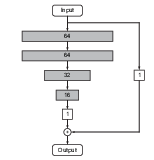

### Dependencies & Prerequisites


In [ ]:
# Install DeepNull into the colab.
!pip install --upgrade pip
!pip install --upgrade deepnull

In [ ]:
# Imports.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
import tensorflow as tf
from typing import Dict, List

from deepnull import config
from deepnull import data
from deepnull import metrics as metrics_lib
from deepnull import model as model_lib
from deepnull import train_eval

Note: Because the total number of features in the DeepNull model is relatively low, it is empirically as fast to run on a CPU-only machine as one with either GPU or TPU accelerators. Ensure you have a CPU-only machine in the following way:

Select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "None".

The following snippet will verify that we are not using a GPU:

In [ ]:
if not tf.test.gpu_device_name():
  print('Good... you are not unnecessarily using a GPU.')
else:
  print(f'WARNING: Found unneccessary GPU: {tf.test.gpu_device_name()}')

## Train your own DeepNull model

The below cells run the code defined above to train your own DeepNull model and provide predictions for a PLINK- or BOLT-formatted input file.

### Load Dataset

First, to train a DeepNull model on your data, your data must be accessible to this colab. You can upload a file from your local machine by clicking the Folder icon on the left of the colab and then the "Upload to session storage" button. Once that successfully completes, your input file should be available within the colab at `/content/<filename>` (the exact path can be manually extracted by clicking the three dots to the right of the filename and selecting "Copy path").

### Required inputs

In [ ]:
input_tsv = '/content/my_input.tsv'  #@param {type: "string"}
target_phenotype = ''  #@param {type: "string"}
covariate_predictors = 'age, sex, genotyping_array'  #@param {type: "string"}
num_folds = 5  #@param {type: "integer"}
input_data_missing_value = 'NA'  #@param {type: "raw"}
output_column_name = 'deepnull_prediction'  #@param {type: "string"}
output_tsv = '/content/my_output.tsv'  #@param {type: "string"}
random_seed = 14475  #@param {type: "integer"}

#### Advanced options

In [ ]:
# These are the parameters used in Hormozdiari et al 2021. The definition of
# each parameter is given in the config class in deepnull/config.py. Note that
# XGBoost models are also available by specifying config.XGBOOST.
full_config = config.get_config(config.DEEPNULL)

# These parameters can be edited directly like in the following statement. Here
# we train for many fewer epochs than a typical run so that the colab finishes
# quickly. Note that this will likely cause the following cell to complain that
# there is poor performance across data folds, since the model folds do not
# converge.
full_config.training_config.num_epochs = 2

## Run the model!

In [ ]:
# Load the input data.
print(f'Loading input data from {input_tsv}...', flush=True)
input_df, binary_field_mapping = data.load_plink_or_bolt_file(
    input_tsv, missing_value=input_data_missing_value)
covariates = data.parse_covariates(covariate_predictors)
target_is_binary = data.is_binary(input_df[target_phenotype])

# Train and evaluate the model. Note that the
# "WARNING:tensorflow:Layers in a Sequential model should only have a single..."
# warning can be safely ignored.
print(f'Training and predicting DeepNull models for {num_folds} data folds...\n',
      flush=True)

tf.random.set_seed(random_seed)
outputs = train_eval.create_deepnull_prediction(
    input_df=input_df,
    target=target_phenotype,
    target_is_binary=target_is_binary,
    covariates=covariates,
    full_config=full_config,
    prediction_column=output_column_name,
    num_folds=num_folds,
    seed=random_seed,
    # Where temporary outputs will be written.
    logdir='/content/deepnull',
    verbosity=1)
output_df, validation_performance, test_perf_df = outputs

if not metrics_lib.acceptable_model_performance(validation_performance):
  print('\n\n##### Warning!! #####')
  print('Poor performance across folds. Consider rerunning this cell with an')
  print('alternative seed as input before writing out the results.')

In [ ]:
# Write the output file.
print(f'\nWriting final predictions to {output_tsv}...', flush=True)
data.write_plink_or_bolt_file(output_df,
                              path_or_buf=output_tsv,
                              binary_column_mapping=binary_field_mapping,
                              missing_value=input_data_missing_value)

if output_tsv.startswith('/content/'):
  print(f'To see the output file "{output_tsv}", right-click in the "Files" '
        'section and select "Refresh".', flush=True)

#### Visualize the performance of the DeepNull model across data folds.

In [ ]:
def plot_binary_model_performance(
    validation_summary_stats: List[Dict[str, float]],
    test_performance_df: pd.DataFrame,
    label_col: str,
    prediction_col: str):
  """Plots performance for binary traits."""
  num_folds = len(validation_summary_stats)
  fig, axs = plt.subplots(1, num_folds, figsize=(num_folds * 4, 5),
                          sharex=True, sharey=True)
  fold_column = f'{label_col}_deepnull_eval_fold'
  for fold, val_performance in enumerate(validation_summary_stats):
    fold_mask = test_performance_df[fold_column] == fold
    test_fold_df = test_performance_df[fold_mask]
    ax = axs[fold]
    sns.regplot(data=test_fold_df, x=prediction_col, y=label_col, ax=ax,
                logistic=True, scatter_kws={'alpha': 0.5})
    # DeepNull and XGBoost name their equivalent metrics slightly differently.
    val_auroc = val_performance.get('auroc') or val_performance.get('auc')
    val_auprc = val_performance.get('auprc') or val_performance.get('aucpr')
    test_auroc = skmetrics.roc_auc_score(test_fold_df[label_col],
                                         test_fold_df[prediction_col])
    test_auprc = skmetrics.average_precision_score(test_fold_df[label_col],
                                                   test_fold_df[prediction_col])
    ax.set_title(f'Fold {fold}\n'
                 f'Validation AUROC: {val_auroc:.2f}\n'
                 f'Validation AUPRC: {val_auprc:.2f}\n'
                 f'Test AUROC: {test_auroc:.2f}\n'
                 f'Test AUPRC: {test_auprc:.2f}')
  plt.tight_layout()


def plot_quantitative_model_performance(
    validation_summary_stats: List[Dict[str, float]],
    test_performance_df: pd.DataFrame,
    label_col: str,
    prediction_col: str):
  """Plots performance for quantitative traits."""
  num_folds = len(validation_summary_stats)
  fig, axs = plt.subplots(1, num_folds, figsize=(num_folds * 4, 5),
                          sharex=True, sharey=True)
  fold_column = f'{label_col}_deepnull_eval_fold'
  for fold, val_performance in enumerate(validation_summary_stats):
    fold_mask = test_performance_df[fold_column] == fold
    test_fold_df = test_performance_df[fold_mask]
    ax = axs[fold]
    sns.regplot(data=test_fold_df, x=prediction_col, y=label_col, ax=ax,
                scatter_kws={'alpha': 0.5})
    # DeepNull and XGBoost name their equivalent metrics slightly differently.
    val_mse = val_performance.get('mse') or val_performance.get('rmse')**2
    val_corr = val_performance.get('tf_pearson') or val_performance.get('pearson')
    test_mse = np.square(test_fold_df[label_col] - test_fold_df[prediction_col]).mean()
    test_corr = np.corrcoef(test_fold_df[label_col], test_fold_df[prediction_col])[0, 1]
    ax.set_title(f'Fold {fold}\n'
                 f'Validation MSE: {val_mse:.2f}\n'
                 f'Validation Pearson R: {val_corr:.2f}\n'
                 f'Test MSE: {test_mse:.2f}\n'
                 f'Test Pearson R: {test_corr:.2f}')
  plt.tight_layout()

In [ ]:
if target_is_binary:
  plot_binary_model_performance(
      validation_summary_stats=validation_performance,
      test_performance_df=test_perf_df,
      label_col=target_phenotype,
      prediction_col=output_column_name)
else:
  plot_quantitative_model_performance(
      validation_summary_stats=validation_performance,
      test_performance_df=test_perf_df,
      label_col=target_phenotype,
      prediction_col=output_column_name)